### 1.1 Descripción del Problema de clasificación.

El dataset de clasificación es el de entrenamiento (train.csv) de la competición de Kaggle (https://www.kaggle.com/competitions/titanic) en la que se propone predecir la columna Survived (que determina si un pasajero del Titanic sobrevivió o no al accidente de este transatlántico) basándose en un set de prueba (test.csv) de la competición para subir las predicciones a Kaggle y ver el accuracy del modelo entrenado en este set de prueba.  

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('titanic.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Como la columna PassangerId no es relevante para el análisis, la eliminamos.

In [56]:
df = df.drop('PassengerId', axis = 1)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
df.shape

(891, 11)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Vamos a pasar la columna Survived a str para que nos sirva el resumen de la función describe.

In [59]:
df['Survived'] = df['Survived'].astype(str)

In [60]:
df.describe(include = [np.number])

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [61]:
df.describe(include = [object])

,Survived,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,204,889
unique,2,891,2,681,147,3
top,0,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,549,1,577,7,4,644


Volvemos a pasar Survived a int para poder entrenar la regresión logística.

In [62]:
df['Survived'] = df['Survived'].astype(int)

In [63]:
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### 2.1 Análisis Exploratorio de Datos (EDA) del problema de clasificación.

In [64]:
df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].skew()

Survived    0.478523
Pclass     -0.630548
Age         0.389108
SibSp       3.695352
Parch       2.749117
Fare        4.787317
dtype: float64

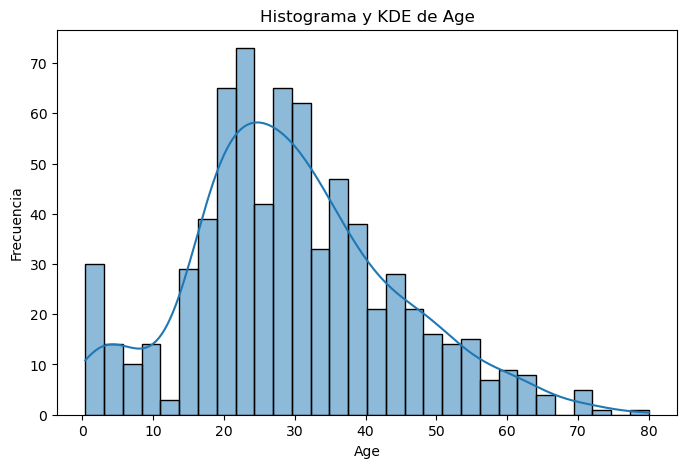

In [65]:
plt.figure(figsize=(8,5))
sns.histplot(df['Age'].dropna(), kde=True, bins=30)
plt.title('Histograma y KDE de Age')
plt.xlabel('Age')
plt.ylabel('Frecuencia')
plt.show()

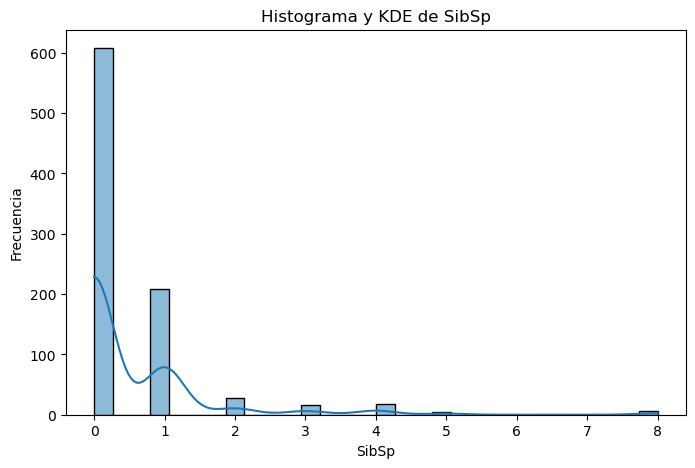

In [66]:
plt.figure(figsize=(8,5))
sns.histplot(df['SibSp'].dropna(), kde=True, bins=30)
plt.title('Histograma y KDE de SibSp')
plt.xlabel('SibSp')
plt.ylabel('Frecuencia')
plt.show()

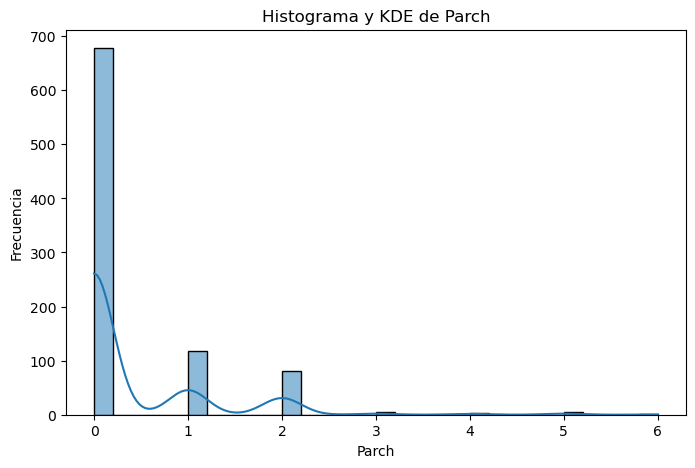

In [67]:
plt.figure(figsize=(8,5))
sns.histplot(df['Parch'].dropna(), kde=True, bins=30)
plt.title('Histograma y KDE de Parch')
plt.xlabel('Parch')
plt.ylabel('Frecuencia')
plt.show()

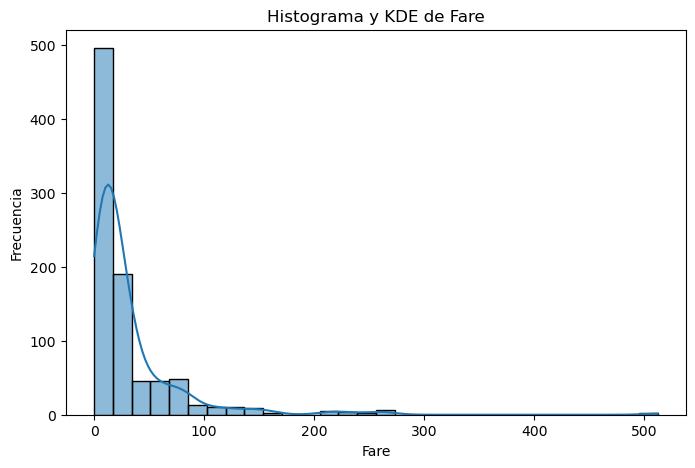

In [68]:
plt.figure(figsize=(8,5))
sns.histplot(df['Fare'].dropna(), kde=True, bins=30)
plt.title('Histograma y KDE de Fare')
plt.xlabel('Fare')
plt.ylabel('Frecuencia')
plt.show()

Text(0.5, 1.0, 'Matriz de Correlación')

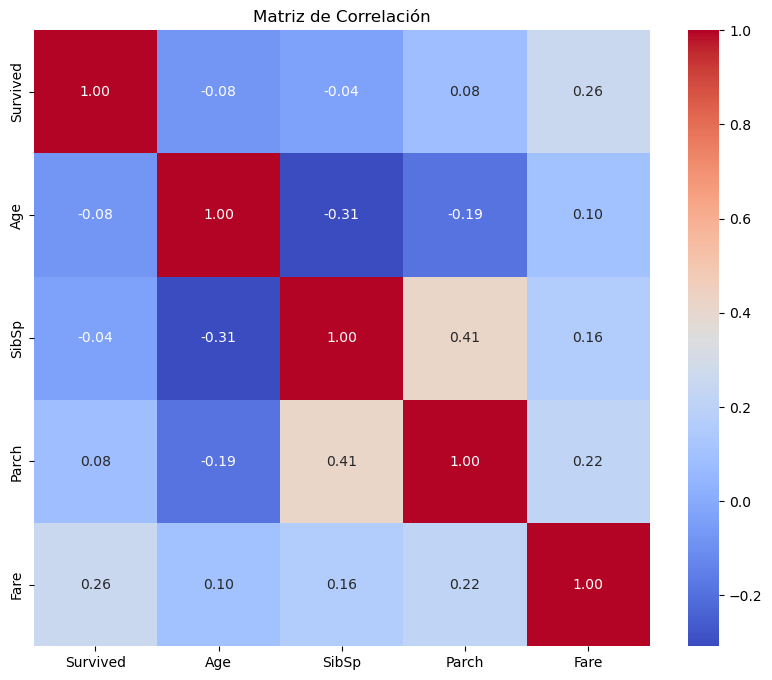

In [69]:
matriz_de_correlacion = df[['Survived','Age', 'SibSp', 'Parch', 'Fare']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_de_correlacion, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')


In [70]:
def crosstabs(df, col1, col2):

    total_filas = len(df)

    valores_no_nulos = df[col2].notna().sum()

    crosstab_index = pd.crosstab(df[col1], df[col2], normalize='index') * 100
    crosstab_index = crosstab_index.round(2)

    crosstab_all = pd.crosstab(df[col1], df[col2], normalize='all') * 100
    crosstab_all = crosstab_all.round(2)

    crosstab_columns = pd.crosstab(df[col1], df[col2], normalize='columns') * 100
    crosstab_columns = crosstab_columns.round(2)

    # El siguiente código es para poder ver las tablas sin tener que scrollear horizontal ni verticalmente en VSC.

    html = f"""
    <div style="display: flex; flex-wrap: wrap; gap: 30px;">
        <div>
            <b>Cantidad total de filas del DataFrame:</b> {total_filas}<br>
            <b>Cantidad de valores no nulos en '{col2}':</b> {valores_no_nulos}
        </div>
        <div>
            <b>Crosstab por índice:</b>
            {crosstab_index.to_html()}
        </div>
        <div>
            <b>Crosstab por total:</b>
            {crosstab_all.to_html()}
        </div>
        <div>
            <b>Crosstab por columnas:</b>
            {crosstab_columns.to_html()}
        </div>
    </div>
    """
    display(HTML(html))

In [71]:
crosstabs(df, 'Survived', 'Pclass')

Pclass,1,2,3
Survived,,,
0,14.57,17.67,67.76
1,39.77,25.44,34.80
Pclass,1,2,3
Survived,,,
0,8.98,10.89,41.75
1,15.26,9.76,13.36
Pclass,1,2,3
Survived,,,
0,37.04,52.72,75.76


Notamos que de los pasajeros que murieron el 67,76% eran de clase baja, el 
41,75% de los pasajeros del dataset eran de clase baja y murieron, y que el 
75,76% de los pasajeros de clase baja no sobrevivieron, esto nos hace pensar que hay una relación entre la variable Survived y la variable Pclass.

In [72]:
df = pd.get_dummies(df, columns=['Pclass'], drop_first=True)

df.head()

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_2,Pclass_3
0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,True
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False
2,1,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,True
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,False
4,0,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,True


In [73]:
crosstabs(df, 'Survived', 'Sex')

Sex,female,male
Survived,,
0,14.75,85.25
1,68.13,31.87
Sex,female,male
Survived,,
0,9.09,52.53
1,26.15,12.23
Sex,female,male
Survived,,
0,25.8,81.11


Notamos que el 85,25% de los no sobrevivientes fueron hombres, y el 68,13% de los pasajeros sobrevivientes fueron mujeres. Además el 52,53% de los pasajeros del Titanic fueron hombres que no sobrevivieron, el 74,2% de las mujeres pasajeras del titanic sobrevivieron y el 81,11% de los pasajeros hombres no sobrevivieron. Todo lo anterior claramente indica una relación entre la variable Sex y la variable Survived.

In [74]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

df.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_2,Pclass_3,Sex_male
0,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,False,True,True
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,False,False,False
2,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,True,False
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,False,False,False
4,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,False,True,True


In [75]:
crosstabs(df, 'SibSp', 'Survived')

Survived,0,1
SibSp,,
0,65.46,34.54
1,46.41,53.59
2,53.57,46.43
3,75.00,25.00
4,83.33,16.67
5,100.00,0.00
8,100.00,0.00
Survived,0,1
SibSp,,


No parece haber un relación fuerte entre la variable SibSp y la variable Survived. No obstante, como la consigna de TP dice que debemos entrenar un modelo con todas las variables independientes y luego con las elegidas por un método de selección o importancia de características, la dejamos en el dataset.

In [76]:
crosstabs(df, 'Survived', 'Parch')

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,81.06,9.65,7.29,0.36,0.73,0.73,0.18
1,68.13,19.01,11.70,0.88,0.00,0.29,0.00
Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,49.94,5.95,4.49,0.22,0.45,0.45,0.11
1,26.15,7.30,4.49,0.34,0.00,0.11,0.00
Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,65.63,44.92,50.0,40.0,100.0,80.0,100.0


In [77]:
crosstabs(df, 'Survived', 'Embarked')

Embarked,C,Q,S
Survived,,,
0,13.66,8.56,77.78
1,27.35,8.82,63.82
Embarked,C,Q,S
Survived,,,
0,8.44,5.29,48.03
1,10.46,3.37,24.41
Embarked,C,Q,S
Survived,,,
0,44.64,61.04,66.3


Vemos que el 66% de los pasajeros que se embarcaron en el puerto de Southampton no sobrevivieron. También notamos que un 72,44% (48,03 + 24,41) de los pasajeros se embarcaron en Southampton (ver "Crosstab por total" de la celda de arriba). Así que completamos la columna Embarked con su moda.

In [78]:
df['Embarked'] = df['Embarked'].fillna('S')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int32  
 1   Name      891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Ticket    891 non-null    object 
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  891 non-null    object 
 9   Pclass_2  891 non-null    bool   
 10  Pclass_3  891 non-null    bool   
 11  Sex_male  891 non-null    bool   
dtypes: bool(3), float64(2), int32(1), int64(2), object(4)
memory usage: 61.9+ KB


In [79]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

df.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,False,True,True,False,True
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,False,False,False,False,False
2,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True,False,False,True
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,False,False,False,False,True
4,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,False,True,True,False,True


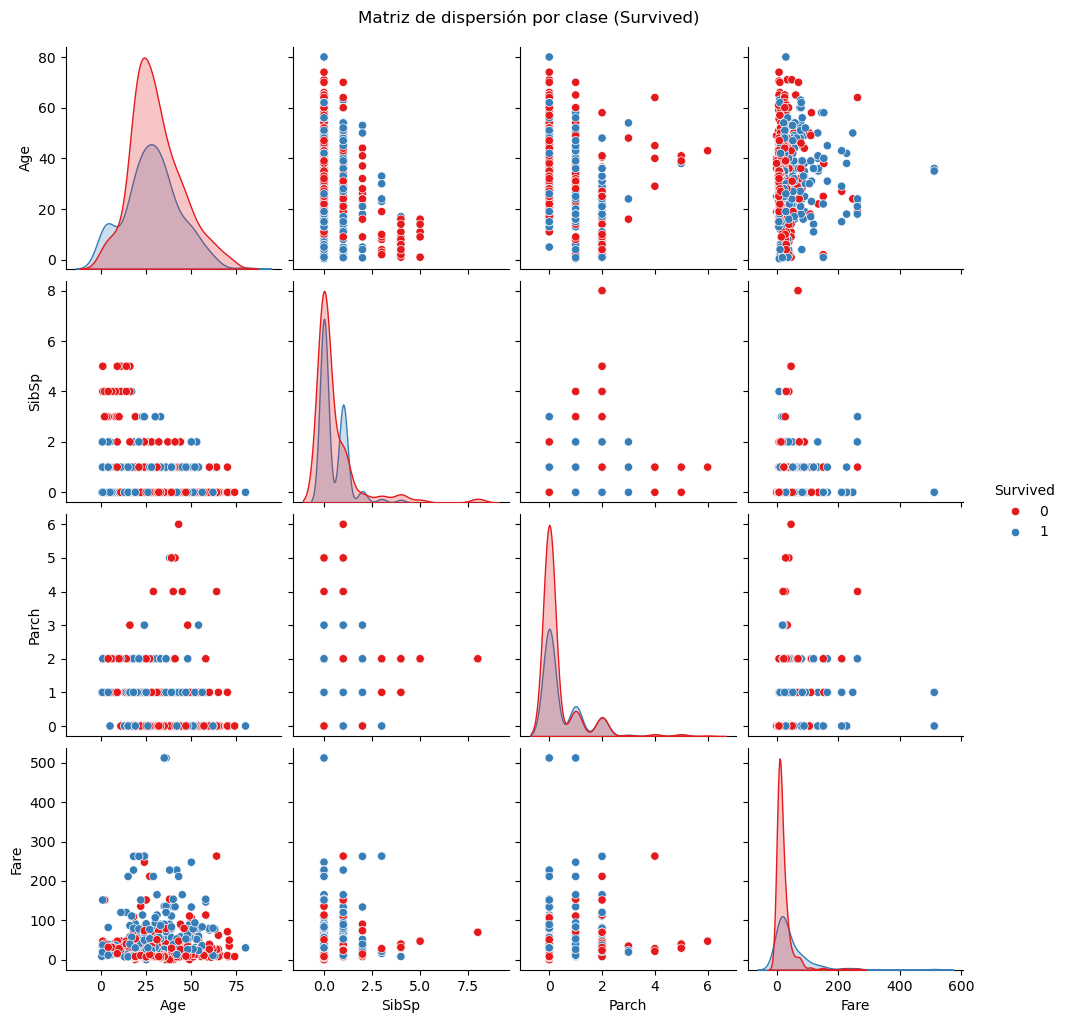

In [80]:
variables = ['Age', 'SibSp', 'Parch', 'Fare']

sns.pairplot(df[variables + ['Survived']], hue='Survived', palette='Set1', diag_kind='kde')
plt.suptitle('Matriz de dispersión por clase (Survived)', y=1.02)
plt.show()

In [81]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int32  
 1   Name        891 non-null    object 
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Ticket      891 non-null    object 
 6   Fare        891 non-null    float64
 7   Cabin       204 non-null    object 
 8   Pclass_2    891 non-null    bool   
 9   Pclass_3    891 non-null    bool   
 10  Sex_male    891 non-null    bool   
 11  Embarked_Q  891 non-null    bool   
 12  Embarked_S  891 non-null    bool   
dtypes: bool(5), float64(2), int32(1), int64(2), object(3)
memory usage: 56.7+ KB


Basándonos en los valores de la columna 'Name' podemos extraer el título (por ejemplo lo que en español sería Sr., Sra., Srta., etc.)

In [82]:
df['Titulo'] = df.Name.str.extract(r'([A-Za-z]+)\.', expand=False)

crosstabs(df, 'Survived', 'Titulo')

Titulo,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,0.18,0.18,0.00,0.18,0.73,0.18,0.00,0.18,3.10,10.02,0.00,0.00,79.42,4.74,0.00,1.09,0.00
1,0.00,0.29,0.29,0.00,0.88,0.00,0.29,0.29,6.73,37.13,0.58,0.29,23.68,28.95,0.29,0.00,0.29
Titulo,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,0.11,0.11,0.00,0.11,0.45,0.11,0.00,0.11,1.91,6.17,0.00,0.00,48.93,2.92,0.00,0.67,0.00
1,0.00,0.11,0.11,0.00,0.34,0.00,0.11,0.11,2.58,14.25,0.22,0.11,9.09,11.11,0.11,0.00,0.11
Titulo,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,100.0,50.0,0.0,100.0,57.14,100.0,0.0,50.0,42.5,30.22,0.0,0.0,84.33,20.8,0.0,100.0,0.0


Podemos convertir los títulos poco frecuentes en la categoría "Otros". También podemos reemplazar términos que son un sinónimo de otro para reducir la cantidad de categorías.

In [83]:
df['Titulo'] = df['Titulo'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Otros')

df['Titulo'] = df['Titulo'].replace('Mlle', 'Miss')
df['Titulo'] = df['Titulo'].replace('Ms', 'Miss')
df['Titulo'] = df['Titulo'].replace('Mme', 'Mrs')

crosstabs(df, 'Survived', 'Titulo')

Titulo,Master,Miss,Mr,Mrs,Otros
Survived,,,,,
0,3.10,10.02,79.42,4.74,2.73
1,6.73,38.01,23.68,29.24,2.34
Titulo,Master,Miss,Mr,Mrs,Otros
Survived,,,,,
0,1.91,6.17,48.93,2.92,1.68
1,2.58,14.59,9.09,11.22,0.90
Titulo,Master,Miss,Mr,Mrs,Otros
Survived,,,,,
0,42.5,29.73,84.33,20.63,65.22


Ahora vamos a eliminar la columna "Name" y hacer one hot encoding con "Titulo".

In [84]:
df = df.drop('Name', axis=1)

df = pd.get_dummies(data = df, columns = ['Titulo'], drop_first = True)

df.head()

,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Titulo_Miss,Titulo_Mr,Titulo_Mrs,Titulo_Otros
0,0,22.0,1,0,A/5 21171,7.2500,NaN,False,True,True,False,True,False,True,False,False
1,1,38.0,1,0,PC 17599,71.2833,C85,False,False,False,False,False,False,False,True,False
2,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True,False,False,True,True,False,False,False
3,1,35.0,1,0,113803,53.1000,C123,False,False,False,False,True,False,False,True,False
4,0,35.0,0,0,373450,8.0500,NaN,False,True,True,False,True,False,True,False,False


Text(0.5, 0.98, '')

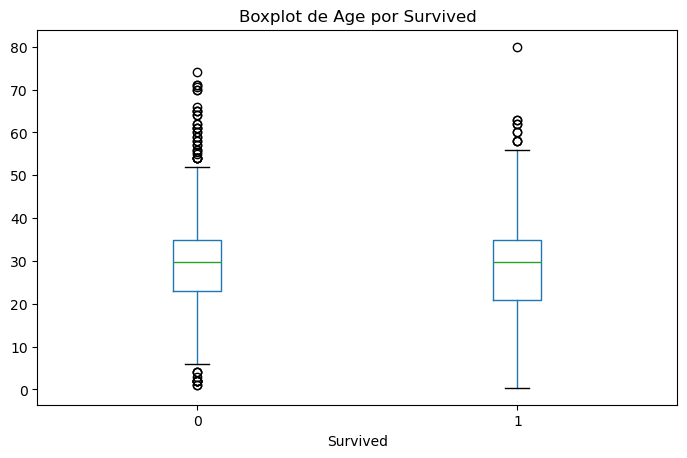

In [85]:
df.boxplot(column='Age', by='Survived', grid=False, figsize=(8, 5))
plt.title('Boxplot de Age por Survived')
plt.suptitle('')

Text(0.5, 0.98, '')

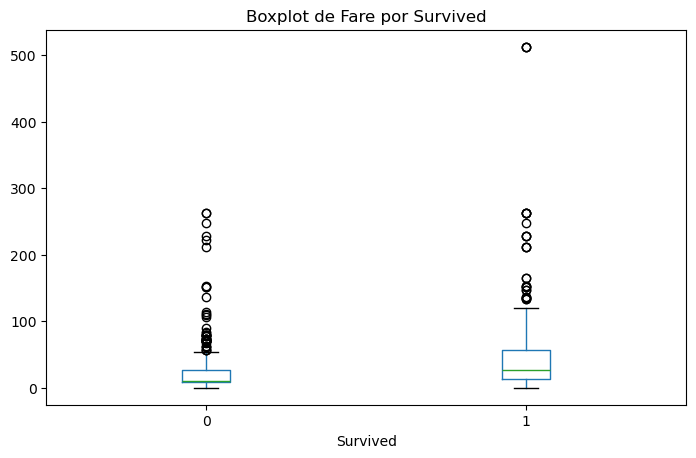

In [86]:
df.boxplot(column='Fare', by='Survived', grid=False, figsize=(8, 5))
plt.title('Boxplot de Fare por Survived')
plt.suptitle('')

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int32  
 1   Age           891 non-null    float64
 2   SibSp         891 non-null    int64  
 3   Parch         891 non-null    int64  
 4   Ticket        891 non-null    object 
 5   Fare          891 non-null    float64
 6   Cabin         204 non-null    object 
 7   Pclass_2      891 non-null    bool   
 8   Pclass_3      891 non-null    bool   
 9   Sex_male      891 non-null    bool   
 10  Embarked_Q    891 non-null    bool   
 11  Embarked_S    891 non-null    bool   
 12  Titulo_Miss   891 non-null    bool   
 13  Titulo_Mr     891 non-null    bool   
 14  Titulo_Mrs    891 non-null    bool   
 15  Titulo_Otros  891 non-null    bool   
dtypes: bool(9), float64(2), int32(1), int64(2), object(2)
memory usage: 53.2+ KB


Vamos a cambiar los valores nulos de la columna Age por el promedio de los datos de esa columna que sí tenemos.

In [88]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int32  
 1   Age           891 non-null    float64
 2   SibSp         891 non-null    int64  
 3   Parch         891 non-null    int64  
 4   Ticket        891 non-null    object 
 5   Fare          891 non-null    float64
 6   Cabin         204 non-null    object 
 7   Pclass_2      891 non-null    bool   
 8   Pclass_3      891 non-null    bool   
 9   Sex_male      891 non-null    bool   
 10  Embarked_Q    891 non-null    bool   
 11  Embarked_S    891 non-null    bool   
 12  Titulo_Miss   891 non-null    bool   
 13  Titulo_Mr     891 non-null    bool   
 14  Titulo_Mrs    891 non-null    bool   
 15  Titulo_Otros  891 non-null    bool   
dtypes: bool(9), float64(2), int32(1), int64(2), object(2)
memory usage: 53.2+ KB


In [89]:
df.head()

,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Titulo_Miss,Titulo_Mr,Titulo_Mrs,Titulo_Otros
0,0,22.0,1,0,A/5 21171,7.2500,NaN,False,True,True,False,True,False,True,False,False
1,1,38.0,1,0,PC 17599,71.2833,C85,False,False,False,False,False,False,False,True,False
2,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True,False,False,True,True,False,False,False
3,1,35.0,1,0,113803,53.1000,C123,False,False,False,False,True,False,False,True,False
4,0,35.0,0,0,373450,8.0500,NaN,False,True,True,False,True,False,True,False,False


In [90]:
df.groupby('Cabin').size().sort_values(ascending=False)

Cabin
C23 C25 C27    4
G6             4
B96 B98        4
F2             3
C22 C26        3
              ..
C101           1
B94            1
B86            1
B82 B84        1
T              1
Length: 147, dtype: int64

Vemos que en las cabinas con más pasejeros había 4 pasajeros, y en las con menos pasajeros había solo un pasajero.

In [91]:
cabin_value_counts = df['Cabin'].value_counts()
cabin_cant_reps = cabin_value_counts.value_counts().sort_index(ascending=False)

print(f"La cantidad de veces que se repite cada cantidad de veces que se repite cada valor de Cabin es: {cabin_cant_reps}")

La cantidad de veces que se repite cada cantidad de veces que se repite cada valor de Cabin es: count
4      3
3      5
2     38
1    101
Name: count, dtype: int64


La mayoría de los pasajeros del dataset estaban solos en sus cabinas. Veamos si hay una relación entre el ticket y la cabina.

In [92]:
df_ticket_no_nan = df[df["Cabin"].notna()]

ticket_value_counts = df_ticket_no_nan['Ticket'].value_counts()
ticket_cant_reps = ticket_value_counts.value_counts().sort_index(ascending=False)

print(f"La cantidad de veces que se repite cada cantidad de veces que se repite cada valor de Ticket es: {ticket_cant_reps}")

La cantidad de veces que se repite cada cantidad de veces que se repite cada valor de Ticket es: count
4     2
3    10
2    36
1    94
Name: count, dtype: int64


Como hay menos repeticiones de solo una vez en ticket_cant_reps que en cabin_cant_reps eso significa que hubo pasajeros con el mismo ticket que fueron a diferentes cabinas. Podemos imputar los Nan´s en la columna Cabin y usar la función crosstabs dividiendo por Nan's y no Nan's.

In [93]:
df['Cabin'] = df['Cabin'].fillna('U')

df['Cabin_is_U'] = df['Cabin'] == 'U'

crosstabs(df, 'Survived', 'Cabin_is_U')

Cabin_is_U,False,True
Survived,,
0,12.39,87.61
1,39.77,60.23
Cabin_is_U,False,True
Survived,,
0,7.63,53.98
1,15.26,23.12
Cabin_is_U,False,True
Survived,,
0,33.33,70.01


Procesemos la columna Cabin_is_U con One-Hot Encoding y eliminemos la columna Cabin.

In [94]:
df = df.drop("Cabin", axis = 1)

df = pd.get_dummies(df, columns=['Cabin_is_U'], drop_first=True)

In [95]:
df.head()

,Survived,Age,SibSp,Parch,Ticket,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Titulo_Miss,Titulo_Mr,Titulo_Mrs,Titulo_Otros,Cabin_is_U_True
0,0,22.0,1,0,A/5 21171,7.2500,False,True,True,False,True,False,True,False,False,True
1,1,38.0,1,0,PC 17599,71.2833,False,False,False,False,False,False,False,True,False,False
2,1,26.0,0,0,STON/O2. 3101282,7.9250,False,True,False,False,True,True,False,False,False,True
3,1,35.0,1,0,113803,53.1000,False,False,False,False,True,False,False,True,False,False
4,0,35.0,0,0,373450,8.0500,False,True,True,False,True,False,True,False,False,True


In [96]:
def eliminar_letras(texto):
  return ''.join([c for c in texto if not c.isalpha()])

df['TicketNumbers'] = df['Ticket'].apply(eliminar_letras)

print(f"Hay {len(df.groupby('TicketNumbers').size())} números diferentes en la columna TickerNumbers")

Hay 681 números diferentes en la columna TickerNumbers


Vemos que no hay números repetidos en la columna TicketNumbers, así que eliminamos esa columna.

In [97]:
df = df.drop("TicketNumbers", axis=1)

In [98]:
def eliminar_numeros(texto):
  return ''.join([c for c in texto if not c.isdigit()]) 

df['TicketLetters'] = df['Ticket'].apply(eliminar_numeros)

print(f"Hay {len(df.groupby("TicketLetters").size())} valores diferentes en la columna TicketLetters")

Hay 43 valores diferentes en la columna TicketLetters


In [99]:
df['Ticket_have_letters'] = df['TicketLetters'] != ''

crosstabs(df, 'Survived', 'Ticket_have_letters')

df = df.drop("TicketLetters", axis=1)

df = df.drop("Ticket", axis=1)

Ticket_have_letters,False,True
Survived,,
0,74.13,25.87
1,74.27,25.73
Ticket_have_letters,False,True
Survived,,
0,45.68,15.94
1,28.51,9.88
Ticket_have_letters,False,True
Survived,,
0,61.57,61.74


In [100]:
df = pd.get_dummies(df, columns=['Ticket_have_letters'], drop_first=True)

df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Titulo_Miss,Titulo_Mr,Titulo_Mrs,Titulo_Otros,Cabin_is_U_True,Ticket_have_letters_True
0,0,22.0,1,0,7.2500,False,True,True,False,True,False,True,False,False,True,True
1,1,38.0,1,0,71.2833,False,False,False,False,False,False,False,True,False,False,True
2,1,26.0,0,0,7.9250,False,True,False,False,True,True,False,False,False,True,True
3,1,35.0,1,0,53.1000,False,False,False,False,True,False,False,True,False,False,False
4,0,35.0,0,0,8.0500,False,True,True,False,True,False,True,False,False,True,False


### 3.1 Preprocesamiento de Datos del problema de clasificación.

In [101]:
array = df.values

X = array[:, 1:]
y = array[:, 0]

print(X)
print(y)

test_size = 0.33  
seed = 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

[[22.0 1 0 ... False True True]
 [38.0 1 0 ... False False True]
 [26.0 0 0 ... False True True]
 ...
 [29.69911764705882 1 2 ... False True True]
 [26.0 0 0 ... False False False]
 [32.0 0 0 ... False True False]]
[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 

In [107]:
log_reg = LogisticRegression(max_iter=1000)

y_train_int = y_train.astype(int) 

rfe = RFE(log_reg, n_features_to_select=3)
fit = rfe.fit(X_train, y_train_int)

np.set_printoptions(precision=2)

print(df.columns)
print(f"Número de Características: {fit.n_features_}")
print(f"Características Seleccionadas: {fit.support_}") 
print(f"Ranking de Características: {fit.ranking_}") 

X_train_rfe = fit.transform(X_train)

X_test_rfe = fit.transform(X_test)

print(X_train)

print(X_test)

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Titulo_Miss', 'Titulo_Mr',
       'Titulo_Mrs', 'Titulo_Otros', 'Cabin_is_U_True',
       'Ticket_have_letters_True'],
      dtype='object')
Número de Características: 3
Características Seleccionadas: [False False False False False  True False False False False  True False
  True False False]
Ranking de Características: [11  5  9 13 12  1  2  7  4  6  1 10  1  3  8]
[[29.69911764705882 1 1 ... False True False]
 [4.0 0 2 ... False False False]
 [58.0 0 2 ... False False False]
 ...
 [30.0 0 0 ... False True True]
 [29.69911764705882 0 0 ... False True False]
 [18.0 1 1 ... False True False]]
[[20.0 0 0 ... False True False]
 [21.0 1 0 ... False True False]
 [39.0 0 0 ... False True False]
 ...
 [24.0 0 0 ... False True False]
 [29.69911764705882 1 0 ... False True False]
 [18.0 0 2 ... False True False]]


In [108]:
np.set_printoptions(precision=2, suppress=True)

k = 8

pca = PCA(n_components=k)

X_train_fit = pca.fit(X_train)

X_train_pca = X_train_fit.transform(X_train)

X_test_pca = pca.transform(X_test) 

print(f"Varianza Explicada: {X_train_fit.explained_variance_ratio_}") 

C = X_train_fit.components_ 

print("Componentes:", C) 

df_pca = pd.DataFrame(data= X_train_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
df_pca

Varianza Explicada: [0.95 0.05 0.   0.   0.   0.   0.   0.  ]
Componentes: [[ 0.03  0.    0.    1.   -0.   -0.   -0.   -0.   -0.    0.   -0.    0.
  -0.   -0.    0.  ]
 [ 1.   -0.02 -0.01 -0.03  0.   -0.01  0.    0.   -0.   -0.01  0.01  0.
   0.   -0.01  0.  ]
 [ 0.03  0.89  0.41 -0.01 -0.    0.03 -0.11 -0.01  0.05  0.04 -0.15  0.07
   0.    0.02  0.02]
 [-0.    0.35 -0.41  0.   -0.08  0.12  0.51 -0.06  0.11 -0.3   0.51 -0.21
  -0.01  0.08  0.07]
 [-0.   -0.28  0.77 -0.    0.05  0.01  0.3  -0.12  0.2  -0.31  0.26  0.01
  -0.01  0.05  0.07]
 [ 0.01 -0.07  0.15  0.   -0.56  0.67 -0.03  0.2  -0.31  0.09  0.05 -0.06
  -0.04  0.18 -0.14]
 [ 0.    0.01  0.08 -0.    0.18 -0.09  0.07  0.18 -0.56  0.08  0.04 -0.14
   0.02  0.14  0.74]
 [ 0.   -0.06 -0.13  0.   -0.07  0.33 -0.22 -0.26  0.57  0.1  -0.09  0.12
  -0.05  0.3   0.55]]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-18.295263,0.581011,0.777661,-0.167424,0.221116,0.684538,0.244386,-0.506549
1,47.616975,-26.835345,-0.700578,-0.731121,1.411799,-0.366705,-0.435647,-0.597661
2,80.453607,26.298319,0.334736,-0.414260,1.425116,0.549214,0.190325,-0.962852
3,45.298937,21.228175,0.749613,-0.568847,-0.939211,-0.010964,-0.173644,-0.439564
4,23.478739,0.812928,0.044997,0.782534,-0.164047,-0.480943,-0.472556,-0.434312
...,...,...,...,...,...,...,...,...
591,-25.560282,3.114713,-0.498914,0.548950,0.265301,0.209105,0.396684,0.704740
592,-25.913657,0.804764,-0.342941,-1.001758,-0.999821,0.911260,0.357793,-0.271685
593,72.858070,-1.496675,-0.838626,-0.701612,-0.857142,0.099266,0.854385,0.417782
594,-25.796749,0.820878,-0.635344,0.327152,-0.125436,0.841839,0.396994,-0.680358


Como con solo 2 componentes ya se capta toda la variación de las variables, volvemos a hacer PCA pero con solo dos componentes.

In [104]:
k = 2

pca = PCA(n_components=k)

X_train_fit = pca.fit(X_train)

X_train_transform = X_train_fit.transform(X_train)

X_test_fit_transform = pca.transform(X_test) 

print(f"Varianza Explicada: {X_train_fit.explained_variance_ratio_}") 

C = X_train_fit.components_ 

print("Componentes:", C) 

df_pca = pd.DataFrame(data= X_train_transform, columns=['PC1', 'PC2'])
df_pca

Varianza Explicada: [0.95 0.05]
Componentes: [[ 0.03  0.    0.    1.   -0.   -0.   -0.   -0.   -0.    0.   -0.    0.
  -0.   -0.    0.  ]
 [ 1.   -0.02 -0.01 -0.03  0.   -0.01  0.    0.   -0.   -0.01  0.01  0.
   0.   -0.01  0.  ]]


,PC1,PC2
0,-18.295263,0.581011
1,47.616975,-26.835345
2,80.453607,26.298319
3,45.298937,21.228175
4,23.478739,0.812928
...,...,...
591,-25.560282,3.114713
592,-25.913657,0.804764
593,72.858070,-1.496675
594,-25.796749,0.820878


In [ ]:
num_folds = 10
seed = 7 

y_train = y_train.astype(int)

log_reg = LogisticRegression(max_iter=1000)

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

scoring="accuracy"

cv_log_reg = cross_val_score(log_reg, X_train, y_train, cv=kfold, scoring=scoring) 

print(f"Accuracy: {round(cv_log_reg.mean(), 2)}")

Accuracy: 0.84


In [110]:
cv_log_reg_rfe = cross_val_score(log_reg, X_train_rfe, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_log_reg_rfe.mean(), 2)}")

Accuracy: 0.81


In [ ]:
cv_log_reg_pca = cross_val_score(log_reg, X_train_pca, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_log_reg_pca.mean(), 2)}")

Accuracy: 0.83


In [115]:
dec_tree = DecisionTreeClassifier()

cv_dec_tree = cross_val_score(dec_tree, X_train, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_dec_tree.mean(), 2)}")

Accuracy: 0.79


In [117]:
cv_dec_tree_rfe = cross_val_score(dec_tree, X_train_rfe, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_dec_tree_rfe.mean(), 2)}")

Accuracy: 0.8


In [118]:
cv_dec_tree_pca = cross_val_score(dec_tree, X_train_pca, y_train, cv=kfold, scoring=scoring)

print(f"Accuracy: {round(cv_dec_tree_pca.mean(), 2)}")

Accuracy: 0.77
